<table class="image">
<caption align="bottom">One of the most notable passengers landing at Dulles.</caption>
<tr><td><img src="./shuttle.jpg" alt="Shuttle Landing At Dulles"/></td></tr>
</table>

# Trends, Tardiness, and Time Series in Air Transport

## Introduction

Whether it is transporting our goods in a timely fashion or transporting us, air transport has become vital to our way of life.  Last year (2017), the commercial airline industry generated $\$750$ billion in revenue and, on average, flew 2.5 million passengers and over 30,000 flights per day.  Broadly, customers fall into three classes - those flying for business, for vacation, or for emergency, i.e. death or sudden illness in the family.  For each group of patrons it is crucial they arrive at their destinations on time and with minimal hassle. Providing this service requires coordination on a massive scale.

Here, we'll take a look at a few characteristics of United flights since I usually fly with them, including the yearly traffic at their busiest hubs and the fraction of flights that are late at each of them.  We'll also explore the late flights a bit and then try to predict the daily United traffic at Dulles for 2018.

We begin by importing a few libraries and functions that are needed for this analysis.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Import specific functions
from datetime import date
import statsmodels.tsa.seasonal as seasonal
import statsmodels.tsa.holtwinters as holtwinters
from pandas.tseries.offsets import YearEnd
from sklearn.metrics import mean_squared_error, r2_score

%load_ext autoreload
%autoreload 2
%matplotlib inline

## The Data

We will use the airline data published by the Bureau of Transportation Statistics (https://www.transtats.bts.gov).  This data is compiled monthly and contains all the relevant details regarding the flight origin and destination, operating carrier, and flight details.  We will look at data from January 2012 through March 2018.  Prior to this analysis, the data is cleaned filtered using reduce_data.py so we can simply load in the .csv file containing the data it produced.  We also need to convert the dates to datetime format, sort the data, and create an additional column containing the flight year to be used for grouping.

In [2]:
# Establish data file and path
DATA_DIR = '../data/'
DATA_FILE = 'united_flight_data.csv'
 
# Read in data and set up
data = pd.read_table(DATA_DIR+DATA_FILE
                     , sep=",")
data = data.dropna()
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'])
data = data.sort_values(by=['FL_DATE'])
data['Flight Year'] = data['FL_DATE'].map(lambda x: x.year)

Next, let's separate out the 2018 flight data for testing later.  We'll begin by looking at yearly flight patterns, so it makes sense to consider data that covers the entire year and remove the incomplete data for 2018.  This removes variations in the typical flight delays because certain time periods may be more prone to delays, e.g. winter.

In [3]:
test_data = data.loc[data['Flight Year'] == 2018]
data = data.loc[data['Flight Year'] < 2018]

## Air Traffic and Departure Delays

Let's first calculate the total number of flights originating from every airport in a given year and find the five busiest.

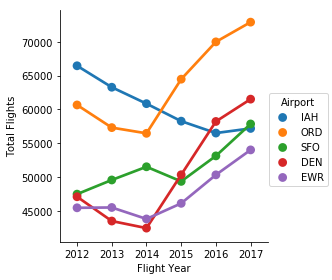

In [4]:
# Group by year
busiest_airports = data.copy()
total_flights = busiest_airports.groupby('Flight Year').ORIGIN \
    .apply(lambda group: group.value_counts() \
    .nlargest(5))

# Tidy up
total_flights = total_flights.reset_index().rename(columns={'level_1': 'Airport', 
                                                            'ORIGIN':'Total Flights'})

# Plot
sns.factorplot(x='Flight Year', y = 'Total Flights', hue = 'Airport', data = total_flights);

Unsurprisingly, the busiest airports are Houston (IAH), Chicago O'Hare (ORD), San Francisco (SFO), Denver (DEN), and Newark (EWR).  Of the top five busiest, all of them have seen a sharp increase in traffic since 2014, with the exception of IAH which has steadily declined.  The growth seen at ORD and DEN is very impressive - about 50% in three years.

When flying, the biggest headaches usually come from delays.  When traveling for work or fun, schedules often leave little room for slippage.  If you are giving at keynote address at a conference, you better be there on time!  Let's see which airports of the five busiest are the most likely to have delayed flights.  We'll be a little lenient and only consider a flight "late" if it is more than 30 minutes.  This is pretty generous and the point at where I become frustrated, at least.

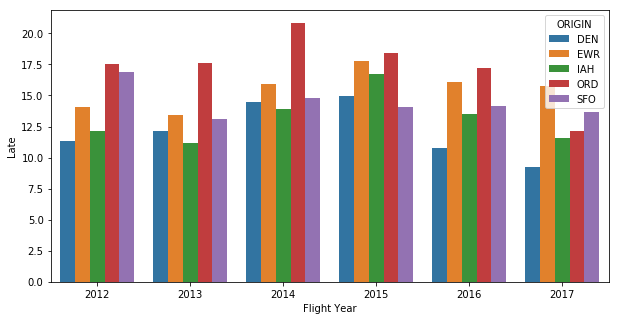

In [5]:
# Filter our airports and get long delays
long_delays = data.copy().loc[data['ORIGIN'].isin(['IAH', 'ORD', 'SFO', 'EWR', 'DEN'])]
long_delays['Late'] = long_delays.DEP_DELAY > 30.

# Get percentage that are late
late_pct = long_delays.groupby(['Flight Year', 'ORIGIN']).Late.mean()*100.
late_pct = late_pct.reset_index()

# Plot
fig, ax = plt.subplots(1,1, figsize= (10,5))
ax = sns.barplot(x='Flight Year', y = 'Late', hue='ORIGIN', data=late_pct);

Across the board, you stand a 10$\%$ or greater chance of having your flight delayed by 30 minutes.  Of the five largest airports, you are most likely to be delayed leaving Chicago, although there was a sharp drop in 2017.  Newark also seems to have trouble with long delays as well.  Delays at Denver were steadily increasing through 2015, but there was a abrupt reversal and they ultimately dropped to the lowest of the group.  

In the future, it may be worth delving into the causes of the delays.  It is a beyond the scope of this project, but the BTS keeps track of the total time attributed to weather, mechanical, and carrier delays.  Including this additional information could elucidate where each airport struggles.  Weather may be more of an issue for Chicago than Houston, for instance, so addressing these causes could improve the hub's performance and the customer experience.

Is there a time when you are more likely to be delayed when flying?  We can approximate this by creating an average distribution of flights departures and delay likelihood across all flights and all airports.  To make this map we'll extract the data for 2017 and place each flight on a plane of departure time and delay (negative means it left early).  We will then use kernel density estimation to get a sense of the probability distribution of a delay and its magnitude for a given time during the day.

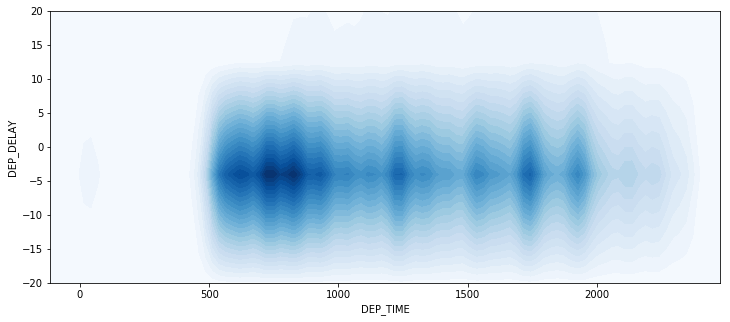

In [6]:
# Get flights in 2017
data_2017 = data[data['Flight Year'] == 2017]

# Plot 
fig, ax = plt.subplots(1,1, figsize= (12,5))
ax = sns.kdeplot(data_2017['DEP_TIME'], 
                 data_2017['DEP_DELAY'], 
                 n_levels=30, 
                 shade=True, 
                 cmap="Blues")
ax.set_ylim([-20, 20]);

Several structures pop out.  The most immediate thing is the density early in the morning.  from 5:00 AM to 10:00 AM the bulk of the flights take off.  Departures settle down until noon, rise, and then die down again until a few evening rushes.  It then remains fairly calm the rest of the evening.  For the most part, the distributions at a given time are symmetric and centered around -4 minutes.  This means you are more likely to leave a bit early and if it will be late, it is rarely more than five minutes.

For delays of less than ten minutes, any features are well-localized to the main departure times.  Looking at the more extreme delays of greater than 30 minutes, we can see a propagation effect.

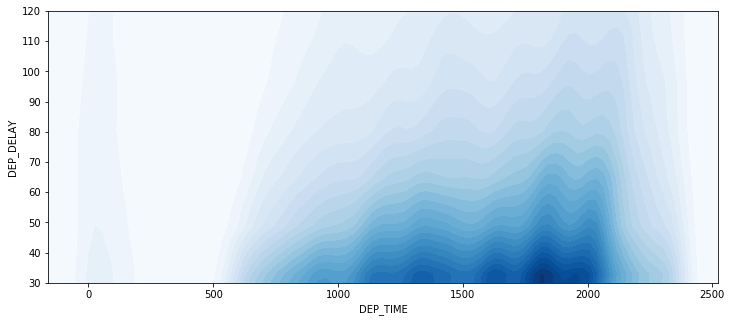

In [7]:
# Cut off the time at 15 minutes to give the 
# estimation a bit of breathing room to to capture 
# the structure at the bottom of the plot

late_2017 = data_2017[data_2017['DEP_DELAY']>15.] 
fig, ax = plt.subplots(1,1, figsize= (12,5))
ax = sns.kdeplot(late_2017['DEP_TIME'], late_2017['DEP_DELAY'], n_levels=30, shade=True, cmap="Blues")
ax.set_ylim([30, 120]);

Corresponding to the bands of increased departures, the longest delays are seen to radiate away.  Presumably, this reflects the relief of back logs or delays that occur during the periods of heavy traffic.  Additionally, it shows that the delays compound and the longest delays are found towards the end of the day, despite most of the flights departing in the morning.

## Daily Air Traffic At Dulles

Let's switch gears and look a the daily traffic at Dulles (IAD).  I'm a creature of habit and fly almost exclusively through there, so I'd like to know when I can expect it to be the busiest.  We could also imagine the airport management would like to predict when United's daily traffic over the next year (2018) so we can plan accordingly.  Let's pretend that for whatever reason the airline won't share the schedule, but we'd like some guidance to schedule staffing, security, maintenance, etc.

We first need to calculate the total daily traffic.  A few other quantities are calculated for data exploration, but are not discussed here (apologies for the code clutter).

In [8]:
# Pull out IAD flights, group by date
dulles_data = data[data['ORIGIN'] == 'IAD'].copy().groupby(pd.Grouper(key= 'FL_DATE', freq= 'D'))

# Set up aggregations
aggregations = {
    'DAY_OF_WEEK':lambda x: x.mode(), 
    'DEP_TIME': ['mean', 'count'],
    'DEP_DELAY': lambda x : x[x > 15].mean(),
    'ARR_TIME': 'mean',
    'CANCELLED': lambda x : x[x == 1.].count(),
    }

# Calculate and get into a usable form
dulles_data = dulles_data.agg(aggregations)
dulles_data.columns = ['_'.join(x) for x in dulles_data.columns.ravel()]
dulles_data = dulles_data.reset_index()
dulles_data = dulles_data.rename(columns={'FL_DATE' : 'Date',
                        'CANCELLED_<lambda>': 'Total_Cancelled', 
                        'DEP_TIME_mean': 'Ave_Departure', 
                        'DEP_TIME_count': 'Total_Flights',
                        'DEP_DELAY_<lambda>' : 'Ave_Delay',
                        'DAY_OF_WEEK_<lambda>' : 'Day_Of_Week_Number',
                        'ARR_TIME_mean' : 'Ave_Arrival'
                       })

# Convert to datetime and set index on date
dulles_data['Date'] = pd.to_datetime(dulles_data['Date'])
dulles_data = dulles_data.set_index('Date')

First things first, let's plot the daily total traffic.

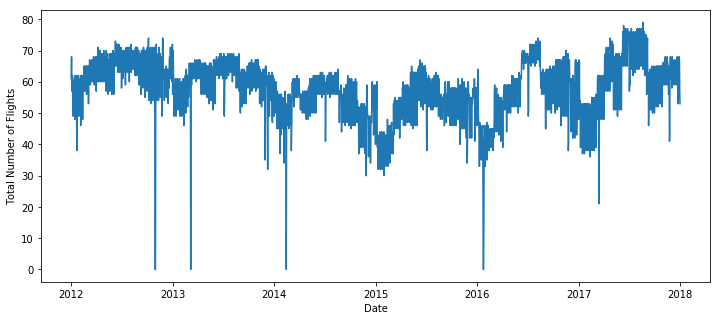

In [9]:
#import matplotlib.dates as mdates
fig, ax = plt.subplots(1,1, figsize= (12,5))
plt.plot(dulles_data['Total_Flights'])
plt.xlabel('Date')
plt.ylabel('Total Number of Flights');

We've crammed about 2,200 points on this plot, so it looks a bit messy, but we can see distinct structure.  There seems to be a multiyear downward trend that reverses at the beginning of 2015.  On top of this, there are relative minima at the beginning of the year before it climbs to relative maxima in the summer.  Its hard to tell if the apparent jumps are periodic or stochastic at this point.  

There also seem to be spurious data points where there are no or very few flights.  Is this real or missing data and what should we do about it?  Let's start by identifying the points with less than 30 flights per day.

In [10]:
outliers = dulles_data[dulles_data['Total_Flights'] < 30].index
print 'Dates of Unusually Low Air Traffic - '
print outliers

Dates of Unusually Low Air Traffic - 
DatetimeIndex(['2012-10-29', '2012-10-30', '2013-03-06', '2014-02-13',
               '2016-01-22', '2016-01-23', '2016-01-24', '2016-01-25',
               '2017-03-14'],
              dtype='datetime64[ns]', name=u'Date', freq=None)


Cross referencing these dates with historical weather data, we can attribute these to snow storms, with the exception of the October 2012 points which may be missing data.  On each of these days the airport received over 4" of snow which is a good bit for this area.  I clearly remember the snow storm spanning January 22-25, 2016.  In College Park, MD we received about 36".  I thought it would be a good opportunity to make some extra money so I went around the neighborhood shoveling driveways.  A sore back and $\$ $50 later I decided I'm better suited to data science than manual labor... but I digress.

These are anomalous events, so we will remove them and interpolate between neighboring points to fill in the gaps.  Hopefully, this better represents what should have been the normal traffic were it not for these one unusual events.  If we were to include them in calibrating our model, their signature might be imprinted on the forecast and skew the results.

In [11]:
# Identify outliers and replace
dulles_data[dulles_data['Total_Flights'] < 30] = np.nan
dulles_data['Total_Flights'] = dulles_data['Total_Flights'].interpolate()

Python makes it easy to decompose a time series into its long term trend, seasonal, and stochastic components.  With the seasonal_decomposition function, you specify the period ("freq" in the documentation) over which you think it should repeat and it applies a convolutional filtering to determine the trend, effectively by "blurring" the time series, and remove it.  It then folds the series over your specified period and averages to get the seasonality.  The trend and seasonality are subtracted to determine the stochastic, or noise, component.  In our flight data, the natural time period for seasonality is a year.  However, a 364 day period is more fitting because travel is mostly determined by the day of the week and we want 52 clean periods.  This may get funny around holidays like Christmas and July 4th, a big one for the DC area, but others like Martin Luther King Day, Easter, and Thanksgiving are set by the day of the week, so it's a trade-off.  I would argue that travel around Christmas and July 4th are also largely determined by the weekdays surrounding them, so our approximation of a year being 364 days is justified.

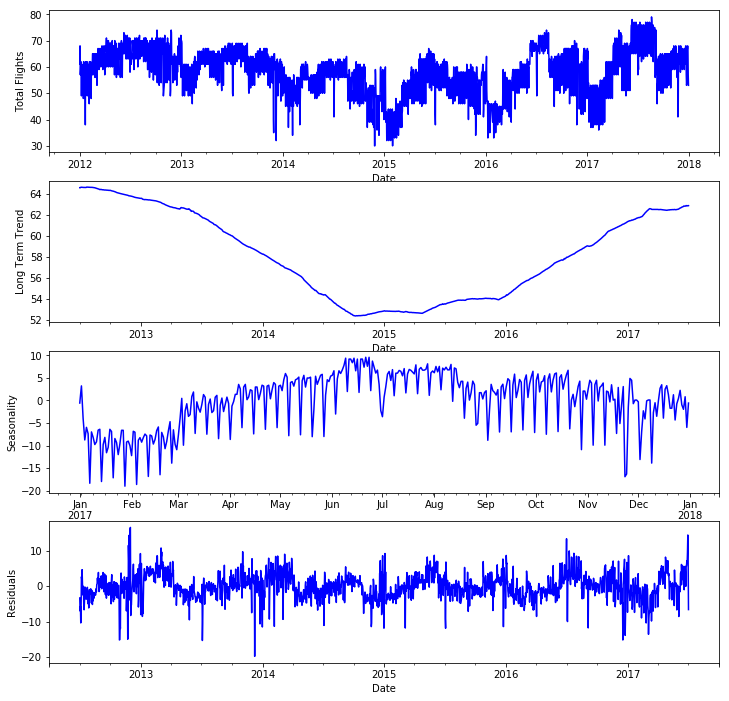

In [12]:
# Perform decomposition
decomp = seasonal.seasonal_decompose(dulles_data['Total_Flights'], model='additive', freq=364)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid
std = np.std(residual)

# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,12))
ax1 = dulles_data['Total_Flights'].plot(ax=ax1, style='b')
ax2 = trend.plot(ax=ax2, style='b')
ax3 = seasonal[-365:].plot(ax=ax3, style='b')
ax4 = residual.plot(ax=ax4, style='b')

ax1.set_ylabel('Total Flights')
ax2.set_ylabel('Long Term Trend')
ax3.set_ylabel('Seasonality')
ax4.set_ylabel('Residuals');

The decomposition does a decent job.  We see there is a decrease in overall flight traffic from the beginning of 2012 through third quarter 2014, it's nearly level through 2015, and then it picks back up at the beginning of 2016.  The seasonal component shows a lull at the beginning of the year, an uptick in travel through the spring, a sustained peak through the summer and a gradual decline.  The residual plot shows random fluctuations that may have some structure from our seasonal estimates not precisely capturing the yearly variability, but it isn't bad.  There are a few blips where the residuals surge or fall, but we are dealing with real data where traveler's decisions are driven by events that algorithms can't capture.

One striking feature captured in the decomposition is the sharp weekly drops.  The total long term trend only varies by 12 flights per day and these drops are roughly that large.  It turns out, those are the total flights on Saturday which are ~10 fewer than the other days of the week.

Average Number Of Flights By Day of Week - 
Day_Of_Week
Friday       61.203195
Monday       60.935250
Saturday     51.786581
Sunday       60.180892
Thursday     60.798722
Tuesday      59.074015
Wednesday    60.314696
Name: Total_Flights, dtype: float64


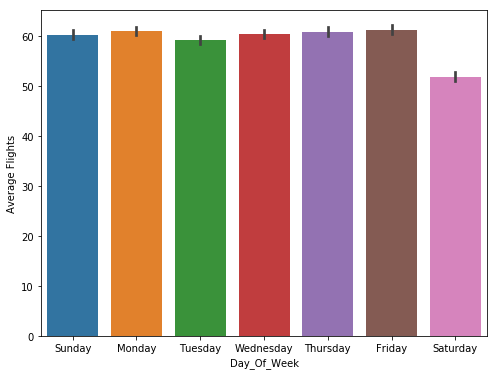

In [13]:
# Group by day of week and get average
dulles_data['Day_Of_Week'] = dulles_data.index.weekday_name
daily_traffic = dulles_data.groupby('Day_Of_Week').Total_Flights.mean()

print 'Average Number Of Flights By Day of Week - '
print daily_traffic

# Plot overall average
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = sns.barplot(x='Day_Of_Week', y='Total_Flights', data = dulles_data)
ax.set_ylabel('Average Flights');

Now let's forecast the 2018 United air traffic at Dulles.  Before going too much further, let's apply the same filtering and aggregation to the test data from the current year we separated earlier.

In [14]:
# Pull out IAD flights, group by date
dulles_test_data = test_data[test_data['ORIGIN'] == 'IAD'].copy() \
                    .groupby(pd.Grouper(key= 'FL_DATE', freq= 'D'))

# Set up aggregations
aggregations = {
    'DAY_OF_WEEK':lambda x: x.mode(), 
    'DEP_TIME': ['mean', 'count'],
    'DEP_DELAY': lambda x : x[x > 15].mean(),
    'ARR_TIME': 'mean',
    'CANCELLED': lambda x : x[x == 1.].count(),
    }

# Calculate and get into a usable form
dulles_test_data = dulles_test_data.agg(aggregations)
dulles_test_data.columns = ['_'.join(x) for x in dulles_test_data.columns.ravel()]
dulles_test_data = dulles_test_data.reset_index()
dulles_test_data = dulles_test_data.rename(columns={'FL_DATE' : 'Date',
                        'CANCELLED_<lambda>': 'Total_Cancelled', 
                        'DEP_TIME_mean': 'Ave_Departure', 
                        'DEP_TIME_count': 'Total_Flights',
                        'DEP_DELAY_<lambda>' : 'Ave_Delay',
                        'DAY_OF_WEEK_<lambda>' : 'Day_Of_Week_Number',
                        'ARR_TIME_mean' : 'Ave_Arrival'
                       })

# Convert to datetime and set index on date
dulles_test_data['Date'] = pd.to_datetime(dulles_test_data['Date'])
dulles_test_data = dulles_test_data.set_index('Date')


For these sorts of predictions, people often employ Auto-Regressive Integrated Moving Average (ARIMA) models.  They are very versatile models whose mathematical framework is applicable in a broad range of problems.  Better suited to our data is a Holt-Winters model.  This model is also referred to as triple exponential smoothing because it applies exponential smoothing in its weighting to the current level, the trend, and the seasonal component. We will fit the model on past data and then predict over the entirety of 2018.  Using the portion of data we have for 2018 from January through March, we can quantify how well our fit is doing using goodness of fit criteria.

In [21]:
test = dulles_test_data['Total_Flights'].copy()
train = dulles_data['Total_Flights'].copy()

fit = holtwinters.ExponentialSmoothing(train ,seasonal_periods=364 ,
                                           trend='add', 
                                           seasonal='add',).fit()

prediction = fit.predict(train.index[0], date(2018,12,31))

/Users/jameshogg/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Now that we have our fit, lets plot all the data.

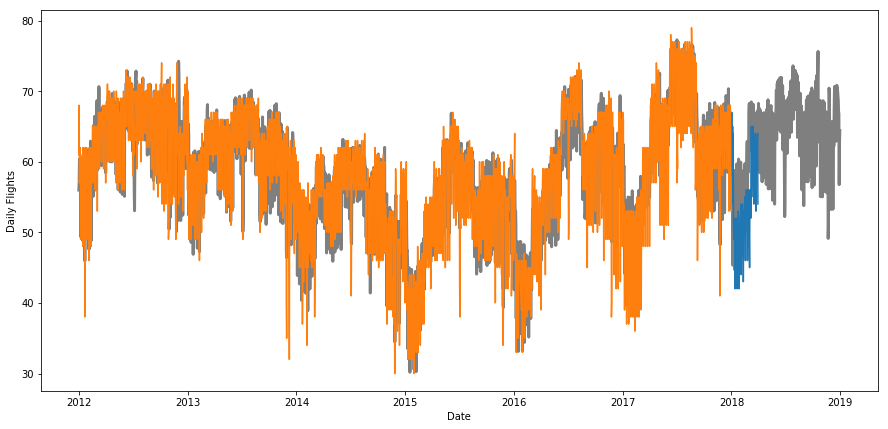

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(prediction.index, prediction, 'k', linewidth = 3, alpha=0.5)
ax.plot(test.index, test)
ax.plot(train.index, train)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Flights');

As with our previous time trace, but now with over 2500 data points, this plot is a bit of a mess because of the sharp drawdowns from weekly fluctuations.  The prediction is shown as the black line, the training data is shown in orange, and the prediction is shown in blue.  Overall, the model seems to be capturing the shape.  In the past, it missed a few of the irregular drops, as we would expect.  The forecast values seem to be overestimating the number of flights, but capturing the shape. Let's zoom in on 2017 and our prediction for 2018.

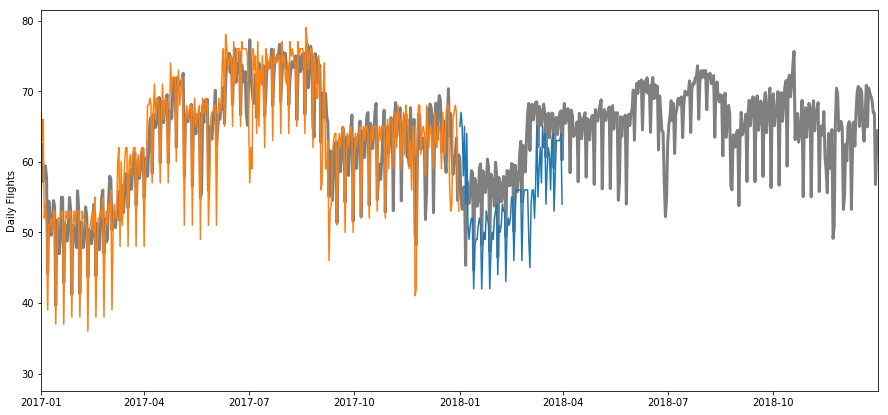

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(prediction.index, prediction, 'k', linewidth = 3, alpha=0.5)
ax.plot(test.index, test)
ax.plot(train.index, train)
ax.set_xlim([prediction.index[-730], prediction.index[-1]])
ax.set_ylabel('Daily Flights');

Indeed, our prediction overestimates the total number of flights by ~5 per day.  Also, the sharp jump upwards is predicted, but a few weeks early.  Maybe spring break is later than past years?  For instance in 2017 and 2018 the spring break at the University of Maryland was a week later than previous years, so this sort of change may explain the discrepancy between the fit and the data.  Also, it looks like our model systematically underestimates the Saturday dips from 2017-2018, so additional revision may be needed there to improve the model.

We can better quantify the goodness of fit with the root mean squared error (RMSE). The standard deviation of the residuals from the seasonal decomposition is shown for comparison. The RMSE is fairly high at ~15%, but not so large the utility of the fit is lost.

In [18]:
predict_comp = prediction[-365:-365+len(test)]

print 'Root Mean Squared Error = ', np.sqrt(mean_squared_error(test, predict_comp))
print 'Sample Standard Deviation = ', std
print r'R2 Score = ', r2_score(test, predict_comp)

Root Mean Squared Error =  7.287770239821852
Sample Standard Deviation =  3.69159698468
R2 Score =  -0.4652272922638878


Plotting the residuals reveals where the model is adequate and where it fails.

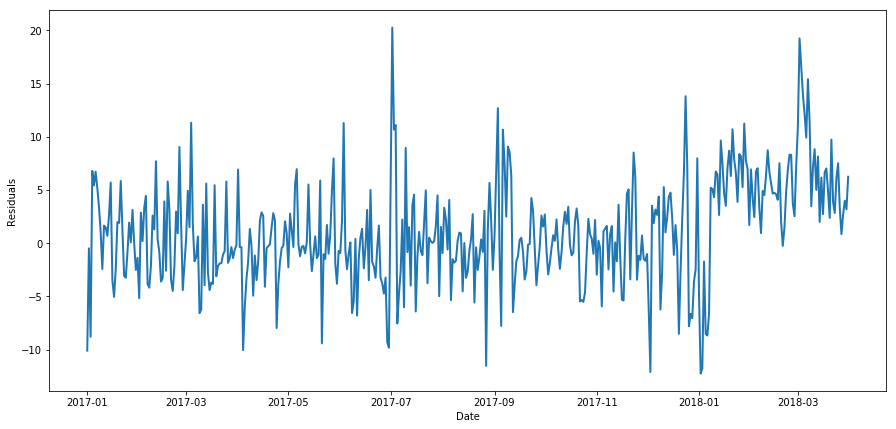

In [19]:
residuals = prediction[-730:-365+len(test)]-train[-365:].append(test)
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(prediction.index[-730:-365+len(test)], residuals, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Residuals');

The underestimation more clearly appears here, although we tend to overestimate the number of Saturday flights earlier on in the dataset, further suggesting there may be trends within our estimation of the seasonality that aren't captured with a simple average.  Additionally, the shelf of positive residuals confirms we are overestimating the number of flights in 2018.  I was, unfortunately, part of the sharp spike of overestimated flights at the beginning of March.  Winter story Toby stranded many travelers across the country (and me at O'Hare).  My thoughts on the matter:

<table class="image">
<caption align="bottom">"Why are you the way that you are?" - Michael Scott</caption>
<tr><td><img src="./toby.jpg" alt="Toby" width="500px"/></td></tr>
</table>

## Summary and Application

We have taken a look at the flight data for United Airlines from 2012 until now.  We found the busiest airports and explored how the delays change as a function of hub and as a function of departure time across all flights.  We've also fit the historic flight information at Dulles with a Holt-Winters model to forecast departures over the next year.  There is room for improvement, but it offers a foundation on which to build in the future.  

Conceivably, this information could help warn travelers when travel days will see heavier or lighter traffic.  In the age of push notifications, a warning a few days before a flight that things will be busy could save the stress of unanticipated delays, or a notification of a light travel day provide customers a few extra minutes at home.  This could also help schedule maintenance days.  If the departures are atypically low on Saturdays in January, that might be the best time to schedule repairs on gates or other facilities.

By changing the input, this analysis could easily be retooled for use in shipping packages, tracking ATM withdrawals, or anticipating visitors to a Caribbean resort.  This type of data aggregation and predictive modeling is very flexible and offers business insights that are otherwise hard to gather.